## Notebook to analyze and visualize strava activities for a specific month

In [1]:
"""Do analysis and make visual for strava activities."""
import gpxpy
import gpxpy.gpx
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import os
from tqdm import tqdm
import shutil

### Identify subdirectory with strava data and set number of frames for animation

In [2]:
# identify export path
export_path = 'export_26262221'

# define the target number of frames for the animation
n_frames = 200

### Load and filter data to relevant activities and timeframe

Currently set up to filter all activities to **runs** in the month of **January 2022**.

This block includes the processing of the GPS tracks to get the lat/lon data in a more easily accessible format.

In [3]:
# load the activities CSV as a pandas dataframe to ID relevant activities
df = pd.read_csv(os.path.join(export_path, 'activities.csv'))

# convert activity date-times to pandas datetime format then filter to 2022
df['datetime'] = pd.to_datetime(df['Activity Date'])
start_date = pd.Timestamp("2022-01-01")
df2022 = df[df['datetime'] >= start_date]
# filter for just january
df_jan = df2022[df2022['datetime'].dt.month == 1]
# filter for just runs
df_jan = df_jan[df_jan['Activity Type'] == 'Run']
df_jan.sort_values(by='datetime', inplace=True)

# create dictionary to store all the gpx tracks
gpx_track = dict()
for i in range(len(df_jan)):
    # path and load gpx file
    _idx = df_jan.index[i]
    _fpath = os.path.join(export_path, df_jan['Filename'][_idx])
    with open(_fpath, 'r') as f:
        _gpx = gpxpy.parse(f)
    # init lat/lon storage for each activity
    gpx_track[_idx] = {'lat': [], 'lon': []}
    # loopy
    for track in _gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                gpx_track[_idx]['lat'].append(point.latitude)
                gpx_track[_idx]['lon'].append(point.longitude)

# turn into a gpx df
df_gpx = pd.DataFrame(gpx_track).T

# merge with existing df
merged = df_jan.join(df_gpx)

Units not obvious, so did some test plots and checked conversions.

Text(0.5, 0, 'Distance [mi]')

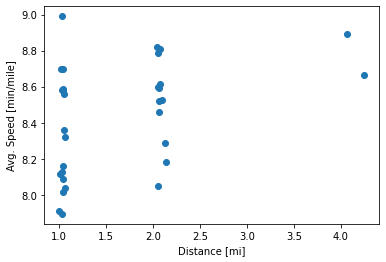

In [4]:
plt.scatter(merged['Distance']/1609.344, 26.8224/merged['Average Speed'])
plt.ylabel('Avg. Speed [min/mile]')
plt.xlabel('Distance [mi]')

Text(0.5, 0, 'Elapsed Time [min]')

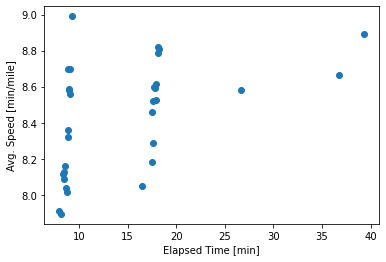

In [5]:
plt.scatter(merged['Elapsed Time']/60, 26.8224/merged['Average Speed'])
plt.ylabel('Avg. Speed [min/mile]')
plt.xlabel('Elapsed Time [min]')

### "Normalization" of tracks

To make it appear as if the runs all start at the same time and happen simultaneously, we normalize the length of the runs by the longest one. To do this, the number of GPS points is used, so we implictly assume regular and steady collection of GPS points along each activity.

Using the target number of frames and the normalized values, the number of GPS points to plot for each frame for each activity is then set in the second cell. These different intervals are what will allow different runs to progress at different rates in the animation.

In [6]:
longest = 0
norm_length = []
true_length = []
# identify longest track
for i in range(len(merged)):
    _idx = merged.index[i]
    true_length.append(len(merged['lon'][_idx]))
    if len(merged['lon'][_idx]) > longest:
        longest = len(merged['lon'][_idx])
# normalize lengths
for i in range(len(merged)):
    _idx = merged.index[i]
    norm_length.append(len(merged['lon'][_idx]) / longest)

In [7]:
# based on number of frames, set intevals for each track
# longest run by elapsed time should use all frames, other tracks should use proportionally less
nidx = []  # number of idx per frame
tidx = []  # number of frames
# calculate number of indices per frame for each
for i in range(len(merged)):
    _idx = merged.index[i]
    _adj_frames = int(norm_length[i] * n_frames)  # number of frames to split track over
    _nidx = int(true_length[i] / (norm_length[i] * n_frames))  # adjust by number of total frames
    tidx.append(_adj_frames)
    nidx.append(_nidx)

## Test Plot! 

Important step here. This sets up the full figure showing full run tracks as well as the subplots and colorbar. Depending on run data the extents of the figure or the locations of the individual subplots and colorbar may need to change! It's far easier to do that here on a static plot than waiting for all the frames to be generated and tweaking things there.

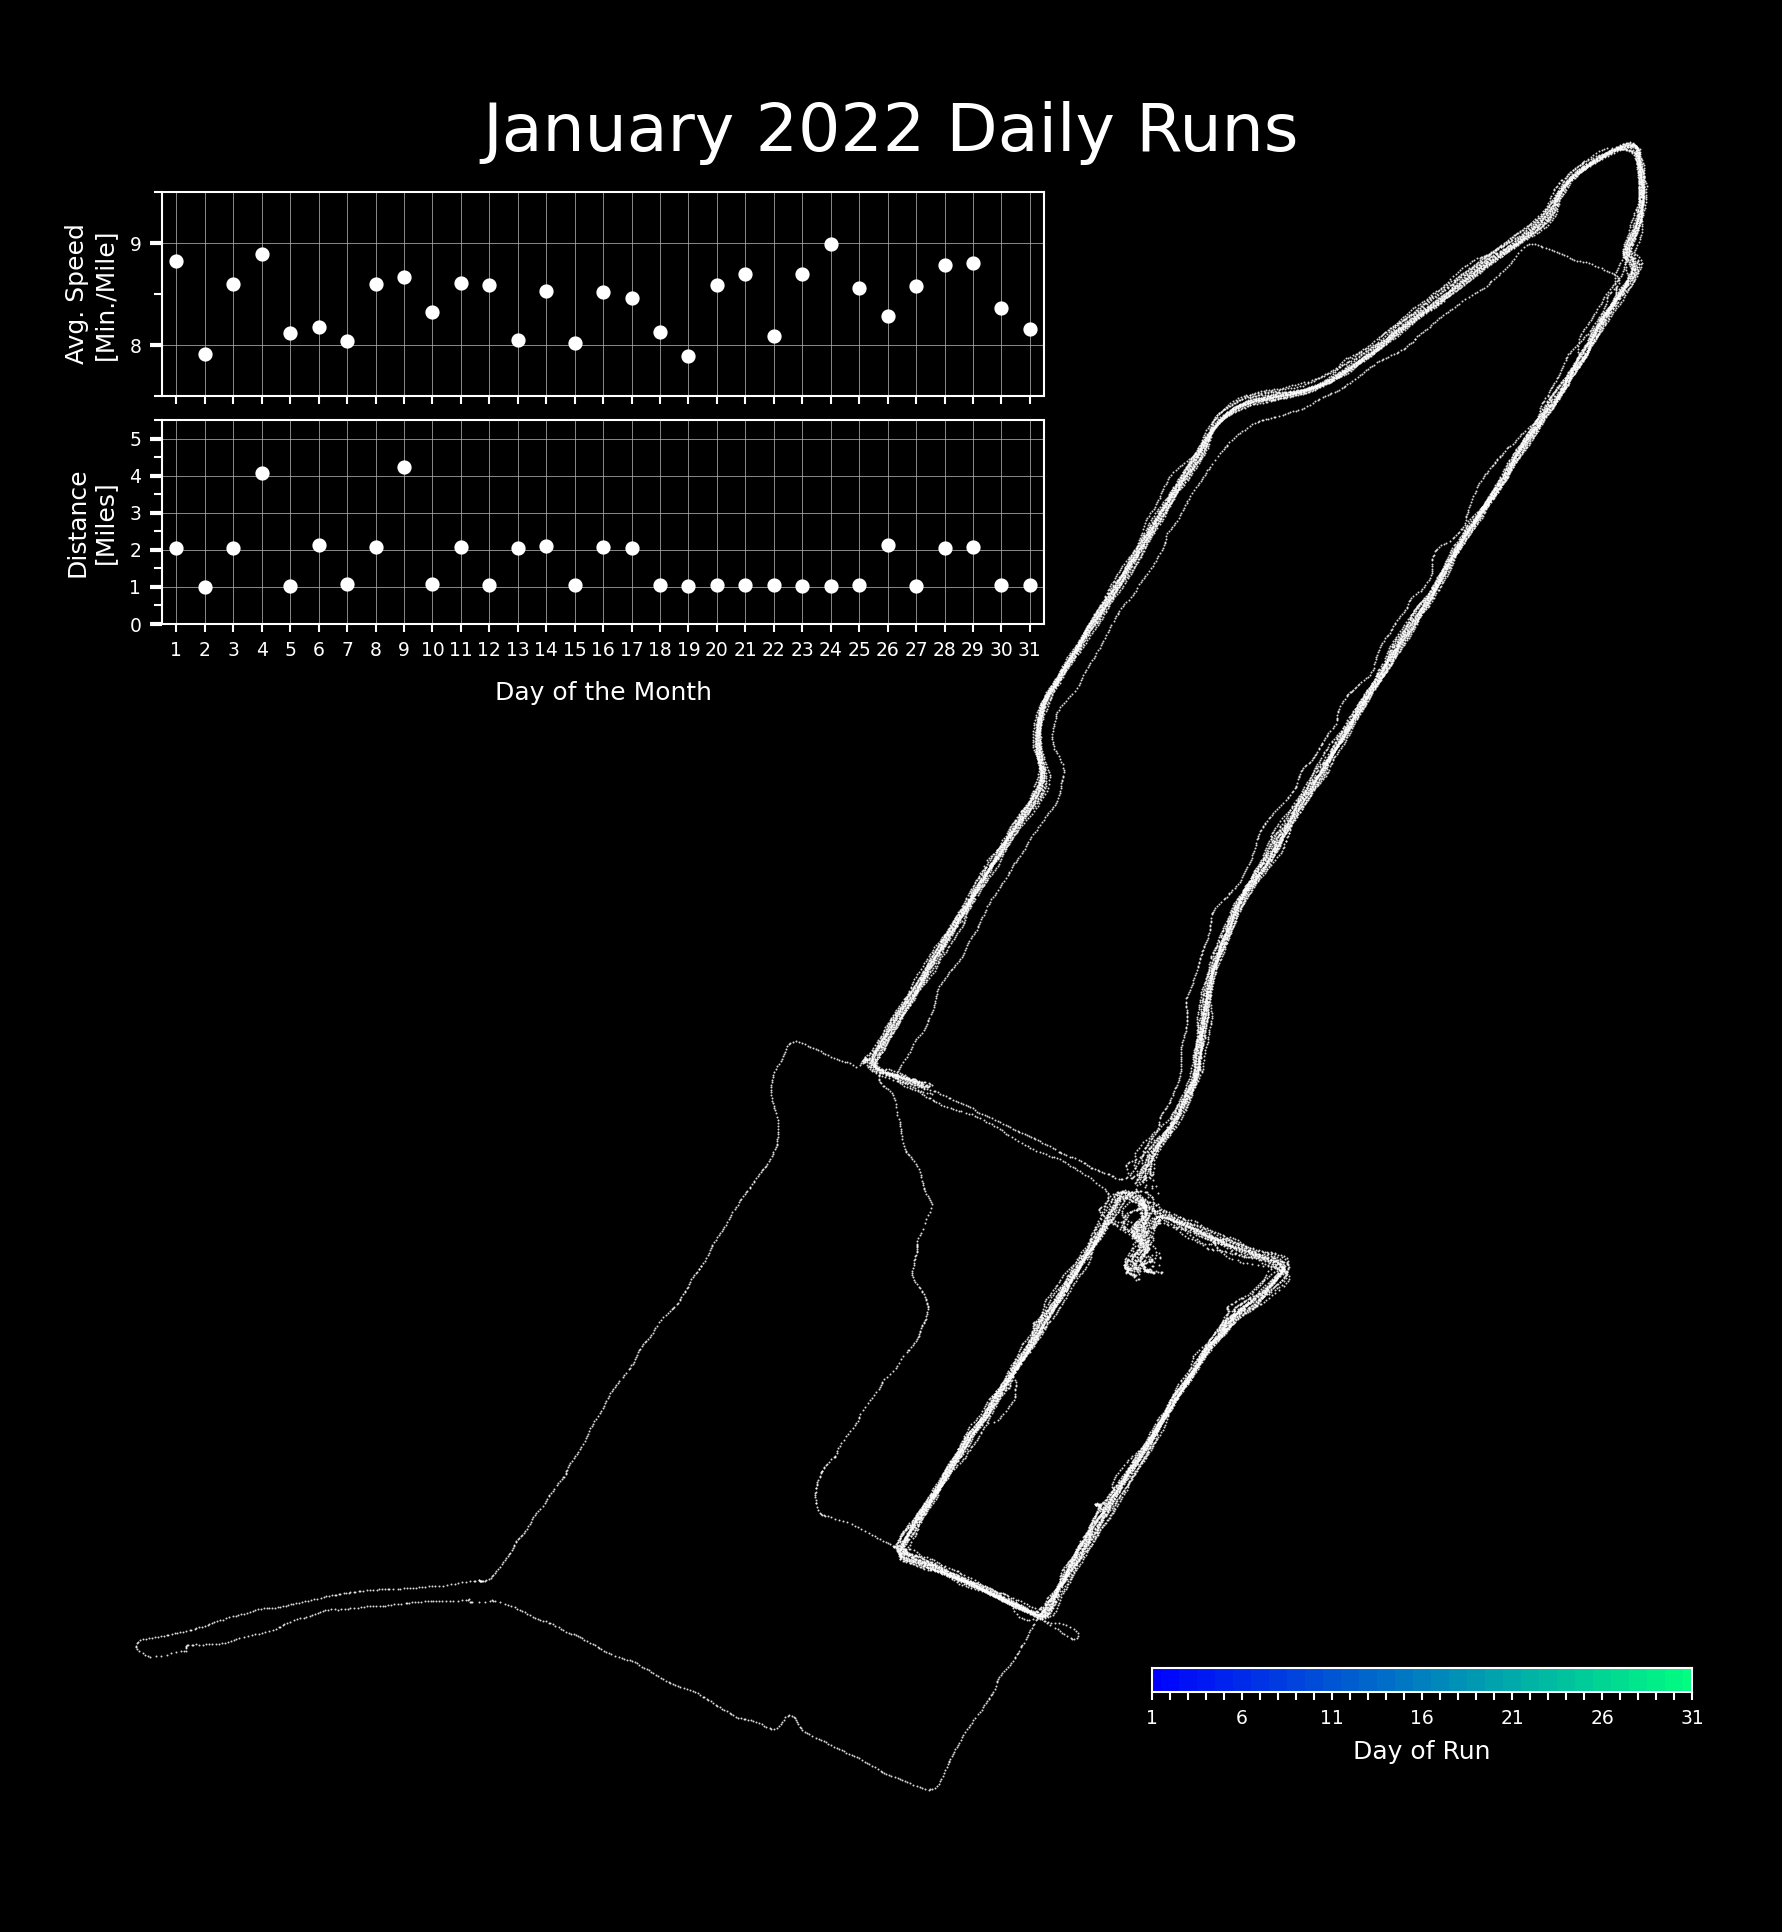

In [8]:
# full tracks test plot
# now have all of the data in one place
fig = plt.figure(dpi=600)
ax = plt.axes(projection=cartopy.crs.Mercator())

# set color cycler
ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0, 1, 31)))

for i in range(len(merged)):
    _idx = merged.index[i]
    # blanks to size plot
    plt.scatter(merged['lon'][_idx], merged['lat'][_idx],
                marker='o', s=0.0, linewidths=0.0, zorder=-50)

    # plot full tracks
    plt.scatter(merged['lon'][_idx][:], merged['lat'][_idx][:],
                marker='o', s=0.05, linewidths=0.01, c='w', alpha=0.85,
                label=merged['datetime'][_idx].day, zorder=-25)         

ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('k')
fig.patch.set_facecolor('k')

# write in title
ax.text(0.5, 0.95, 'January 2022 Daily Runs',
        fontsize=8, c='w',
        horizontalalignment='center',
        fontvariant='small-caps',
        transform=ax.transAxes)

# add axes
# viz avg speed
top_ax = fig.add_axes([0.31, 0.74, 0.245, 0.085], facecolor='k')
top_ax.scatter(
    merged['datetime'].dt.day, 26.8224/merged['Average Speed'],
    marker='o', c='w', s=0.5, zorder=5)
top_ax.set_yticks(np.arange(8, 10, 1))
top_ax.set_yticks(np.arange(7.5, 10, 0.5), minor=True)
top_ax.tick_params(axis='both', which='both', colors='w', labelsize=2.25)
top_ax.tick_params(axis='y', which='major', length=1.5, width=0.5, pad=1.)
top_ax.tick_params(axis='y', which='minor', length=1, width=0.25, pad=1.)
top_ax.tick_params(axis='x', which='both', length=1, width=0.25, pad=1.)
top_ax.set_xticks(np.arange(1, 32))
for sp in top_ax.spines.values():
    sp.set_edgecolor('w')
    sp.set_linewidth(0.25)
top_ax.set_ylabel('Avg. Speed\n[Min./Mile]', c='w', fontsize=3, labelpad=1.5)
top_ax.set_xlim([0.5, 31.5])
top_ax.set_xticklabels([])
top_ax.grid(zorder=-500, alpha=0.9, linewidth=0.1)

# viz distance
mid_ax = fig.add_axes([0.31, 0.645, 0.245, 0.085], facecolor='k')
mid_ax.scatter(
    merged['datetime'].dt.day, merged['Distance']/1609.344,
    marker='o', c='w', s=0.5, zorder=5)
mid_ax.set_yticks(np.arange(0, 6, 1))
mid_ax.set_yticks(np.arange(0.5, 6, 0.5), minor=True)
mid_ax.tick_params(axis='both', which='both', colors='w', labelsize=2.25)
mid_ax.tick_params(axis='y', which='major', length=1.5, width=0.5, pad=1.)
mid_ax.tick_params(axis='y', which='minor', length=1, width=0.25, pad=1.)
mid_ax.tick_params(axis='x', which='both', length=1, width=0.25, pad=1.)
mid_ax.set_xticks(np.arange(1, 32))
for sp in mid_ax.spines.values():
    sp.set_edgecolor('w')
    sp.set_linewidth(0.25)
mid_ax.set_ylabel('Distance\n[Miles]', c='w', fontsize=3, labelpad=1.5)
mid_ax.set_xlim([0.5, 31.5])
mid_ax.grid(zorder=-500, alpha=0.9, linewidth=0.1)
mid_ax.set_xlabel('Day of the Month', c='w', fontsize=3, labelpad=2.5)

# viz color cycler
c_ax = fig.add_axes([0.585, 0.2, 0.15, 0.01], facecolor='c')
gradient = np.linspace(0, 1, 31)
gradient = np.vstack((gradient, gradient))
c_ax.imshow(gradient, aspect='auto', cmap='winter')
c_ax.set_yticks([])
c_ax.tick_params(axis='x', which='both', colors='w', labelsize=2.25)
c_ax.tick_params(axis='x', which='both', length=1, width=0.25, pad=1.)
c_ax.set_xticks(np.arange(0, 31, 5))
c_ax.set_xticklabels(np.arange(1, 36, 5))
c_ax.set_xticks(np.arange(0, 31, 1), minor=True)
for sp in c_ax.spines.values():
    sp.set_edgecolor('w')
    sp.set_linewidth(0.25)
c_ax.set_xlabel('Day of Run', c='w', fontsize=3, labelpad=1.5)
c_ax.set_xlim([0, 30])


plt.show()

## Make Animation Frames

If the above plot looks good, then make sure to transfer the manual adjustments to the cell below where the individual frames are drawn and saved. The frames for the animation are put into a subdirectory `frames/` where they will be numbered sequentially from `00000.png` to `nframes.png`. The size of the "leading" bit of the run and the increment runs advance is based on the number of frames: more frames = smaller increments.

To turn the individual frames into an animation I used the commandline tool `ffmpeg` although there are ways to get in done in Python

In [9]:
# delete frames subdirectory
try:
    shutil.rmtree('frames')
except:
    pass

# re-create it
os.mkdir('frames')

In [10]:
# now have all of the data in one place
for f in tqdm(range(n_frames)):
    fig = plt.figure(dpi=600)
    ax = plt.axes(projection=cartopy.crs.Mercator())
    
    # set color cycler
    ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0, 1, 31)))

    for i in range(len(merged)):
        _idx = merged.index[i]
        # blanks to size plot
        plt.scatter(merged['lon'][_idx], merged['lat'][_idx],
                    marker='o', s=0.0, linewidths=0.0, zorder=-50)
        # complex plotting
        interval = (f*nidx[i], f*nidx[i] + nidx[i])  # tuple of interval
        
        # always plot where track was
        plt.scatter(merged['lon'][_idx][:interval[1]], merged['lat'][_idx][:interval[1]],
                    marker='o', s=0.03, linewidths=0.01, c='w', alpha=0.95,
                    label=merged['datetime'][_idx].day, zorder=-25)
        
        # decide whether or not to add distance
        if f < tidx[i]:            
            plt.scatter(merged['lon'][_idx][interval[0]:interval[1]], merged['lat'][_idx][interval[0]:interval[1]],
                    marker='o', s=0.7, linewidths=0.1,
                    label=merged['datetime'][_idx].day)
            
        elif f == tidx[i]:            
            # make sure it goes to final track - aka dont risk rounding off
            plt.scatter(merged['lon'][_idx][interval[0]:], merged['lat'][_idx][interval[0]:],
                    marker='o', s=0.7, linewidths=0.1,
                    label=merged['datetime'][_idx].day)            
            
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('k')
    fig.patch.set_facecolor('k')
    
    # write in title
    ax.text(0.5, 0.95, 'January 2022 Daily Runs',
            fontsize=8, c='w',
            horizontalalignment='center',
            fontvariant='small-caps',
            transform=ax.transAxes)

    # add axes
    # viz avg speed
    top_ax = fig.add_axes([0.31, 0.74, 0.245, 0.085], facecolor='k')
    top_ax.scatter(
        merged['datetime'].dt.day, 26.8224/merged['Average Speed'],
        marker='o', c='w', s=0.5, zorder=5)
    top_ax.set_yticks(np.arange(8, 10, 1))
    top_ax.set_yticks(np.arange(7.5, 10, 0.5), minor=True)
    top_ax.tick_params(axis='both', which='both', colors='w', labelsize=2.25)
    top_ax.tick_params(axis='y', which='major', length=1.5, width=0.5, pad=1.)
    top_ax.tick_params(axis='y', which='minor', length=1, width=0.25, pad=1.)
    top_ax.tick_params(axis='x', which='both', length=1, width=0.25, pad=1.)
    top_ax.set_xticks(np.arange(1, 32))
    for sp in top_ax.spines.values():
        sp.set_edgecolor('w')
        sp.set_linewidth(0.25)
    top_ax.set_ylabel('Avg. Speed\n[Min./Mile]', c='w', fontsize=3, labelpad=1.5)
    top_ax.set_xlim([0.5, 31.5])
    top_ax.set_xticklabels([])
    top_ax.grid(zorder=-500, alpha=0.9, linewidth=0.1)

    # viz distance
    mid_ax = fig.add_axes([0.31, 0.645, 0.245, 0.085], facecolor='k')
    mid_ax.scatter(
        merged['datetime'].dt.day, merged['Distance']/1609.344,
        marker='o', c='w', s=0.5, zorder=5)
    mid_ax.set_yticks(np.arange(0, 6, 1))
    mid_ax.set_yticks(np.arange(0.5, 6, 0.5), minor=True)
    mid_ax.tick_params(axis='both', which='both', colors='w', labelsize=2.25)
    mid_ax.tick_params(axis='y', which='major', length=1.5, width=0.5, pad=1.)
    mid_ax.tick_params(axis='y', which='minor', length=1, width=0.25, pad=1.)
    mid_ax.tick_params(axis='x', which='both', length=1, width=0.25, pad=1.)
    mid_ax.set_xticks(np.arange(1, 32))
    for sp in mid_ax.spines.values():
        sp.set_edgecolor('w')
        sp.set_linewidth(0.25)
    mid_ax.set_ylabel('Distance\n[Miles]', c='w', fontsize=3, labelpad=1.5)
    mid_ax.set_xlim([0.5, 31.5])
    mid_ax.grid(zorder=-500, alpha=0.9, linewidth=0.1)
    mid_ax.set_xlabel('Day of the Month', c='w', fontsize=3, labelpad=2.5)

    # viz color cycler
    c_ax = fig.add_axes([0.585, 0.2, 0.15, 0.01], facecolor='c')
    gradient = np.linspace(0, 1, 31)
    gradient = np.vstack((gradient, gradient))
    c_ax.imshow(gradient, aspect='auto', cmap='winter')
    c_ax.set_yticks([])
    c_ax.tick_params(axis='x', which='both', colors='w', labelsize=2.25)
    c_ax.tick_params(axis='x', which='both', length=1, width=0.25, pad=1.)
    c_ax.set_xticks(np.arange(0, 31, 5))
    c_ax.set_xticklabels(np.arange(1, 36, 5))
    c_ax.set_xticks(np.arange(0, 31, 1), minor=True)
    for sp in c_ax.spines.values():
        sp.set_edgecolor('w')
        sp.set_linewidth(0.25)
    c_ax.set_xlabel('Day of Run', c='w', fontsize=3, labelpad=1.5)
    c_ax.set_xlim([0, 30])

    plt.savefig('frames/' + str(f).zfill(5) + '.png', dpi=600, bbox_inches='tight', pad_inches=0.0)
    
    plt.close()

100%|█████████████████████████████████████████| 200/200 [04:48<00:00,  1.44s/it]
